In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Load model and data

In [2]:
ckpt_path = '../models/RotatE_wn18_0'
data_path = '../data/wn18'

In [3]:
print('Loading checkpoint %s...' % ckpt_path)
checkpoint = torch.load(os.path.join(ckpt_path, 'checkpoint'), map_location='cpu')
entity_embedding = checkpoint['model_state_dict']['entity_embedding']
relation_embedding = checkpoint['model_state_dict']['relation_embedding']
embedding_range = checkpoint['model_state_dict']['embedding_range']

Loading checkpoint ../models/RotatE_wn18_0...


In [4]:
def read_triple(file_path, entity2id, relation2id):
    '''
    Read triples and map them into ids.
    '''
    triples = []
    with open(file_path) as fin:
        for line in fin:
            h, r, t = line.strip().split('\t')
            triples.append((entity2id[h], relation2id[r], entity2id[t]))
    return triples

with open(os.path.join(data_path, 'entities.dict')) as fin:
    entity2id = dict()
    for line in fin:
        eid, entity = line.strip().split('\t')
        entity2id[entity] = int(eid)

with open(os.path.join(data_path, 'relations.dict')) as fin:
    relation2id = dict()
    for line in fin:
        rid, relation = line.strip().split('\t')
        relation2id[relation] = int(rid)
            
train_triples = read_triple(os.path.join(data_path, 'train.txt'), entity2id, relation2id)
train_triples = torch.LongTensor(train_triples)

# Chose entity to visualize

In [15]:
subset = []
length = []
indices = []

for relation_id in range(18):
    for entity_id in range(40000):
        mask = (train_triples[:, 0] == entity_id) * (train_triples[:, 1] == relation_id)
        nonzero = torch.nonzero(mask).squeeze(1)
        subset.append(nonzero)
        length.append(nonzero.shape[0])
        indices.append((entity_id, relation_id))


In [51]:
nzr = np.nonzero(np.asarray(length))[0]
for i in range(10):
    print(nzr[i], length[nzr[i]], indices[nzr[i]])

282 4
394 2
443 1
835 1
1039 9
1496 14
1552 2
1649 4
1679 11
1994 35


In [ ]:
argmax = np.argmax(np.asarray(length))
print(length[argmax])
entity_id, relation_id = indices[argmax]
subset_indices = subset[argmax]
tail_id = train_triples[subset_indices, 2]



In [16]:
pi = 3.14159265358979323846

entity_id = 23354
relation_id = 10

mask = (train_triples[:, 0] == entity_id) * (train_triples[:, 1] == relation_id)
nonzero = torch.nonzero(mask).squeeze(1)
tail_id = train_triples[nonzero, 2]
print(entity_id, relation_id, tail_id.shape[0])

head = entity_embedding[entity_id, :].unsqueeze(0)
tails = entity_embedding[tail_id, :]
relation = relation_embedding[relation_id, :]


re_head, im_head = torch.chunk(head, 2, dim=1)
re_tail, im_tail = torch.chunk(tails, 2, dim=1)

        
phase_relation = relation/(embedding_range.item()/pi)
re_relation = torch.cos(phase_relation)
im_relation = torch.sin(phase_relation)

re_score = re_head * re_relation - im_head * im_relation
im_score = re_head * im_relation + im_head * re_relation

score = torch.stack([re_score, im_score], dim = 0)

diff = (re_tail - score[0]) ** 2 + (im_tail - score[1]) ** 2
print(diff.shape)


23354 10 471
torch.Size([471, 500])


# Visualize points

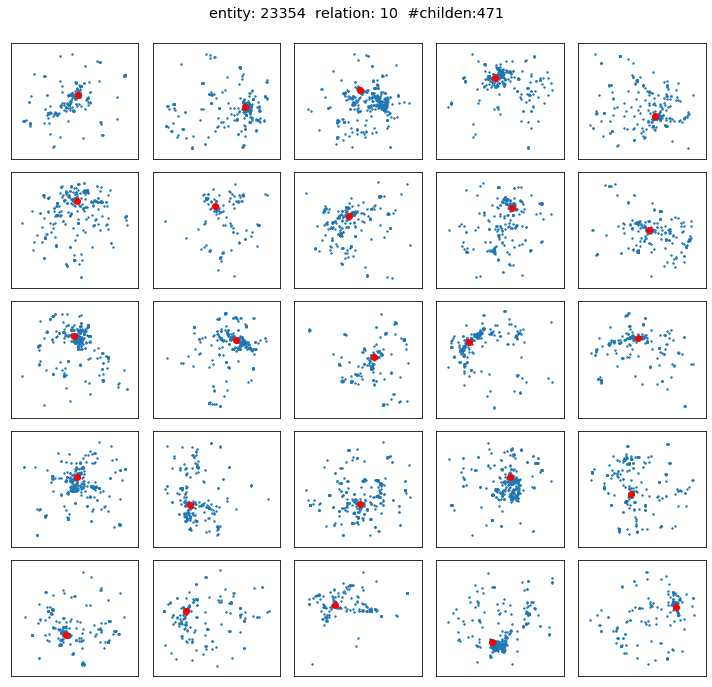

In [41]:
fig = plt.figure(figsize=(10, 10), frameon=False)
N = 5
markersize=2.0

st = fig.suptitle("entity: %d  relation: %d  #childen:%d" % (entity_id, relation_id, tail_id.shape[0]), fontsize="x-large")


for i in range(N ** 2):
    dim = i
    plt.subplot(N, N, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.scatter(re_tail[:, dim], im_tail[:, dim], s=markersize)
    plt.scatter(re_score[:, dim], im_score[:, dim], color='red')

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.90)
fig.savefig("./figures/e_%d_r_%d_childen_%d.png" % (entity_id, relation_id, tail_id.shape[0]))
